In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary as sel
from qiskit.transpiler.passes import BasisTranslator
from qiskit.circuit.library import XGate, YGate, CXGate
service = QiskitRuntimeService()

from qiskit.circuit.classical import expr   # allows classical logic on mid circuit measurement

In [2]:
from qiskit.visualization import timeline_drawer

In [3]:
backend1 = service.backend("ibm_brisbane") 
target = backend1.target
basis_gates = list(target.operation_names)

In [4]:
 X = XGate()
Y = YGate()
CX=CXGate()
dd_sequence = [X, X]

In [5]:
y_gate_properties = {}
cx_gate_properties = {}
for qubit in range(target.num_qubits):
    y_gate_properties.update(
        {
            (qubit,): InstructionProperties(
                duration=target["x"][(qubit,)].duration,
                error=target["x"][(qubit,)].error,
            )
        }
    )

"""for qubit in range(target.num_qubits):
    cx_gate_properties.update(
        {
            (qubit,qubit): InstructionProperties(
                duration=9*target["x"][(qubit,)].duration,
                error=target["x"][(qubit,)].error,
            )
        }
    )
"""
 
target.add_instruction(YGate(), y_gate_properties)
#target.add_instruction(CXGate(), cx_gate_properties)

In [6]:
dd_pm = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        PadDynamicalDecoupling(target=target, dd_sequence=dd_sequence),
    ]
)


In [7]:
# optional
from qiskit.visualization import timeline_drawer
 
#timeline_drawer(qc_dd, show_idle=False)

In [ ]:
# last step of dynamical decoupling pass 

#qc_dd.draw("mpl", fold=-1, idle_wires=False)

In [8]:
def get_ghz_circ_static(num_qubit):
    if num_qubit%2==1:                                                     #odd no of qubits
        qr=QuantumRegister(num_qubit)
        cr2=ClassicalRegister(num_qubit,name="cr2")                     
        qc=QuantumCircuit(qr,cr2)
        mid_qubit_index=int((num_qubit-1)/2)
        qc.h(mid_qubit_index)
        for i in range(mid_qubit_index,num_qubit-1):
            qc.cx(i,i+1)
            qc.cx(num_qubit-i-1,num_qubit-i-2)
        

    else:                                                                    #even no of qubits
        qr=QuantumRegister(num_qubit)
        cr2=ClassicalRegister(num_qubit,name="cr2")                     
        qc=QuantumCircuit(qr,cr2)
        mid_qubit_index=int((num_qubit-2)/2)
        qc.h(mid_qubit_index)
        for i in range(mid_qubit_index,num_qubit-2):
            qc.cx(i,i+1)
            qc.cx(num_qubit-1-i-1,num_qubit-i-3)
        qc.cx(num_qubit-2,num_qubit-1)
    for i in range(num_qubit):
        qc.measure(qr[i],cr2[i])
    return qc

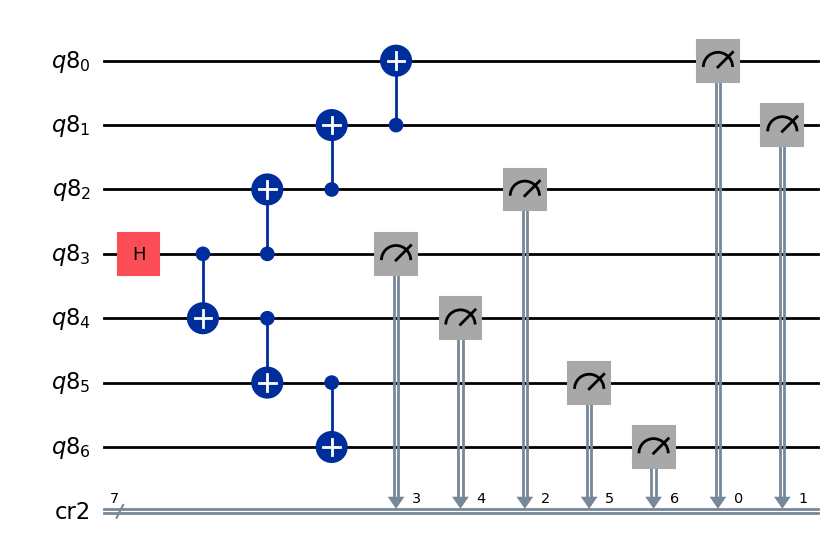

In [22]:
qc = get_ghz_circ_static(num_qubit=7)
qc.draw("mpl")

In [9]:
def get_ghz_circ_dynamic_1(num_qubit):   
    if num_qubit%2==1:                                                  # For odd number of qubits
        qr=QuantumRegister(num_qubit)
        num_mid_measurements=int(num_qubit/2)
        cr1=ClassicalRegister(num_mid_measurements,name="cr1")          # mid circuit measurement
        cr2=ClassicalRegister(num_qubit,name="cr2")                     # final measurement
        qc=QuantumCircuit(qr,cr1,cr2)
        for i in range(num_mid_measurements+1):
            qc.h(2*i)
        qc.barrier()
        for i in range(num_mid_measurements):
            qc.cx(2*i+2,2*i+1)
            qc.cx(2*i,2*i+1)
        qc.barrier()
        for i in range(num_mid_measurements):
            qc.measure(2*i+1,cr1[i])
            if i==0:
                parity=expr.lift(cr1[i])
            else :
                parity=expr.bit_xor(cr1[i],parity)
            with qc.if_test(parity):
                    qc.x(2*i+2)
    
        for i in range(num_mid_measurements):
            parity=expr.lift(cr1[i])
            with qc.if_test(parity):
                qc.x(2*i+1)
            qc.cx(2*i,2*i+1)

    else:                                                               # For even number of Qubits
        qr=QuantumRegister(num_qubit)
        num_mid_measurements=int((num_qubit-1)/2)
        cr1=ClassicalRegister(num_mid_measurements,name="cr1")          # mid circuit measurement
        cr2=ClassicalRegister(num_qubit,name="cr2")                     # final measurement
        qc=QuantumCircuit(qr,cr1,cr2)
        for i in range(num_mid_measurements+1):
            qc.h(2*i)
        
        for i in range(num_mid_measurements):
            qc.cx(2*i+2,2*i+1)
            qc.cx(2*i,2*i+1)
        
        for i in range(num_mid_measurements):
            qc.measure(2*i+1,cr1[i])
            if i==0:
                parity=expr.lift(cr1[i])
            else :
                parity=expr.bit_xor(cr1[i],parity)
            with qc.if_test(parity):
                    qc.x(2*i+2)
    
        for i in range(num_mid_measurements):
            parity=expr.lift(cr1[i])
            with qc.if_test(parity):
                qc.x(2*i+1)
            qc.cx(2*i,2*i+1)
        qc.cx(num_qubit-2,num_qubit-1)
    for i in range(num_qubit):
        qc.measure(qr[i],cr2[i])
    return qc

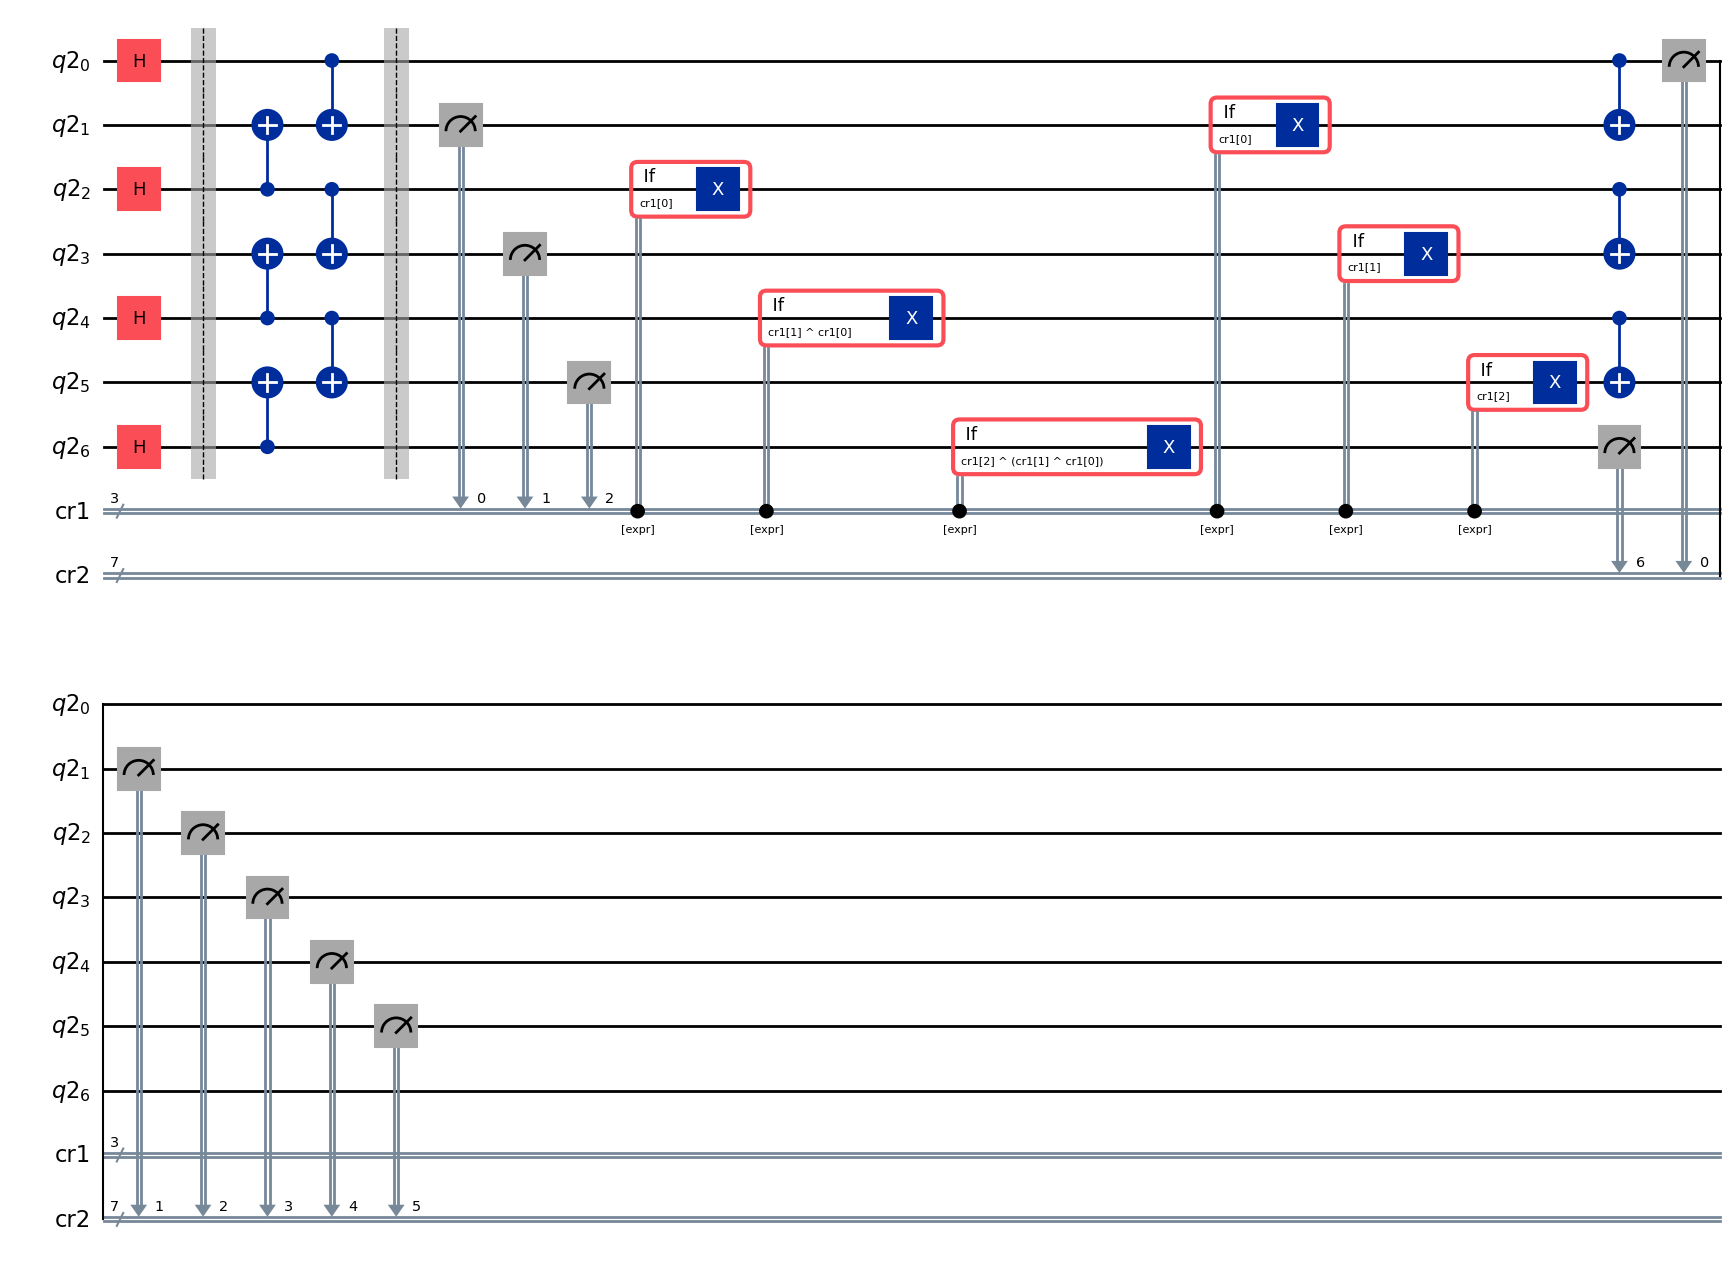

In [9]:
qc = get_ghz_circ_dynamic_1(num_qubit=7)
qc.draw("mpl")

In [6]:
#dynamic circuit using qubit-reuse in aersimulator

In [10]:
def get_ghz_circ_static_1(num_qubit):
    if num_qubit%2==1:                                                     #odd no of qubits
        qr=QuantumRegister(num_qubit)
        cr2=ClassicalRegister(num_qubit,name="cr2")                     
        qc=QuantumCircuit(qr,cr2)
        mid_qubit_index=int((num_qubit-1)/2)
        qc.h(mid_qubit_index)
        for i in range(mid_qubit_index,num_qubit-1):
            qc.cx(i,i+1)
            qc.cx(num_qubit-i-1,num_qubit-i-2)
        

    else:                                                                    #even no of qubits
        qr=QuantumRegister(num_qubit)
        cr2=ClassicalRegister(num_qubit,name="cr2")                     
        qc=QuantumCircuit(qr,cr2)
        mid_qubit_index=int((num_qubit-2)/2)
        qc.h(mid_qubit_index)
        for i in range(mid_qubit_index,num_qubit-2):
            qc.cx(i,i+1)
            qc.cx(num_qubit-1-i-1,num_qubit-i-3)
        qc.cx(num_qubit-2,num_qubit-1)
    for i in range(num_qubit):
        qc.measure(qr[i],cr2[i])
    return qc

In [11]:
#creating dynamic circuit from a separate static circuit
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

def get_ghz_circ_dynamic_2(num_qubit):
    qc=get_ghz_circ_static_1(num_qubit)
    aer_sim = AerSimulator()
    pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1, init_method="qubit_reuse")
    transpiled_qc = pm.run(qc)
    
    return transpiled_qc

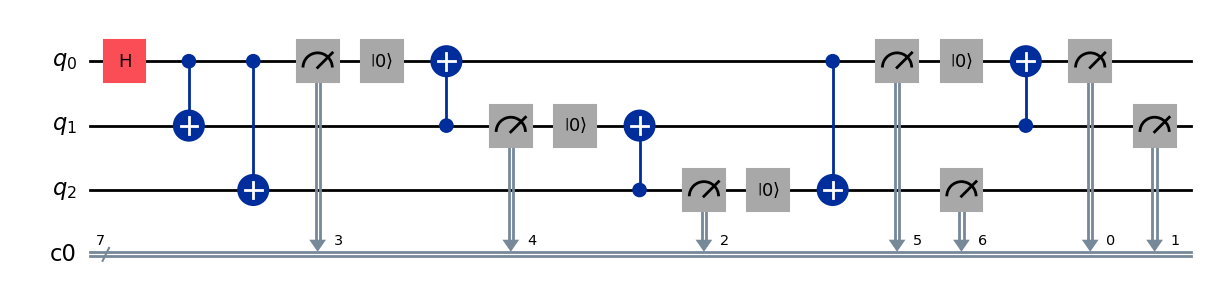

In [11]:
qc = get_ghz_circ_dynamic_2(num_qubit=7)
qc.draw("mpl")

In [12]:
#Creating list of circuits[Static_1, Dynamic1_1, Dynamic2_1, Static_1, Dynamic1_1, Dynamic2_1,...,Static_2, Dynamic1_2, Dynamic2_2, Static_2, Dynamic1_2, Dynamic2_2,...] i.e. some copies of each of them

min_qubit=3
max_num_qubit=9
copies=3

#qc_list_dynamic_1=[]
#qc_list_dynamic_2=[]
#qc_list_static=[]
#observables=[]

qc_list=[]
num_qubit_list=list(range(min_qubit,max_num_qubit+1,2))
for num_qubit in num_qubit_list:
    for i in range(copies):
        qc_list.append(get_ghz_circ_static(num_qubit))
        #qc_list.append(get_ghz_circ_dynamic_1(num_qubit))
        qc_list.append(get_ghz_circ_dynamic_2(num_qubit))
print(num_qubit_list)

[3, 5, 7, 9]


In [13]:
#Ideal Simulation with AerSimulator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=2,basis_gates=basis_gates)
qc_transpiled_list=[]

qc_transpiled_list_ideal = pm.run(qc_list)

In [14]:
sampler = Sampler(backend=aer_sim)
result_ideal = sampler.run(qc_transpiled_list_ideal).result()

In [15]:
print(result_ideal)
len(result_ideal)

PrimitiveResult([PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))), PubResult(data=DataBin(c0=BitArray(<shape=(), num_shots=1024, num_bits=3>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))), PubResult(data=DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=3>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))), PubResult(data=DataBin(c4=BitArray(<shape=(), num_shots=1024, num_bits=3>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=5>))), PubResult(data=DataBin(c6=BitArray(<shape=(), num_shots=1024, num_bits=5>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=5>))), PubResult(data=DataBin(c8=BitArray(<shape=(), num_shots=1024, num_bits=5>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=5>))), PubResult(data=DataBin(c10=BitArray(<shape=(), num_shots=1024, num_bits=5>))), PubResult(data=DataBin(cr2=BitArray(<sha

24

In [16]:
# For getting list of ideal counts (argument required for Fidelity)
counts_list_ideal=[]
k=0
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_static = result_ideal[(2*i*copies)+(2*j)].data    
        #data_dynamic_1 = result_ideal[(3*i*copies)+((3*j)+1)].data 
        data_dynamic_2 = result_ideal[(2*i*copies)+((2*j)+1)].data

        print(data_static)
        #print(data_dynamic_1)
        print(data_dynamic_2)
        
        counts_static=data_static.cr2.get_counts()
        #counts_dynamic_1=data_dynamic_1.cr2.get_counts()
        
        # Replacing 'cr2' with the appropriate attribute if needed
        dynamic_2_attr_name = f'c{2*(k)}'
        if hasattr(data_dynamic_2, dynamic_2_attr_name):
            counts_dynamic_2 = getattr(data_dynamic_2, dynamic_2_attr_name).get_counts()
        else:
            raise AttributeError(f"{dynamic_2_attr_name} not found in data_dynamic_2")
        
        counts_list_ideal.append(counts_static)
        #counts_list_ideal.append(counts_dynamic_1)
        counts_list_ideal.append(counts_dynamic_2)
        k=k+1

DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(c0=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(c4=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=5>))
DataBin(c6=BitArray(<shape=(), num_shots=1024, num_bits=5>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=5>))
DataBin(c8=BitArray(<shape=(), num_shots=1024, num_bits=5>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=5>))
DataBin(c10=BitArray(<shape=(), num_shots=1024, num_bits=5>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=7>))
DataBin(c12=BitArray(<shape=(), num_shots=1024, num_bits=7>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=7>))
DataBin(c14=BitArray(<shape=(), num_shots=1024, num_bits=7>))
DataBin(cr2=B

In [17]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

 
# Save an IBM Quantum account and set it as your default account.

 
# Load saved credentials
service = QiskitRuntimeService()
backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.get_backend(backend_name)
pm = generate_preset_pass_manager(optimization_level=2, backend=backend, basis_gates=basis_gates)
qc_transpiled_list = pm.run(qc_list)
qc_dd_list=[]
for qc_transpiled in qc_transpiled_list:
    qc_dd = dd_pm.run(qc_transpiled)
    qc_dd = BasisTranslator(sel, basis_gates)(qc_dd)
    qc_dd_list.append(qc_dd)

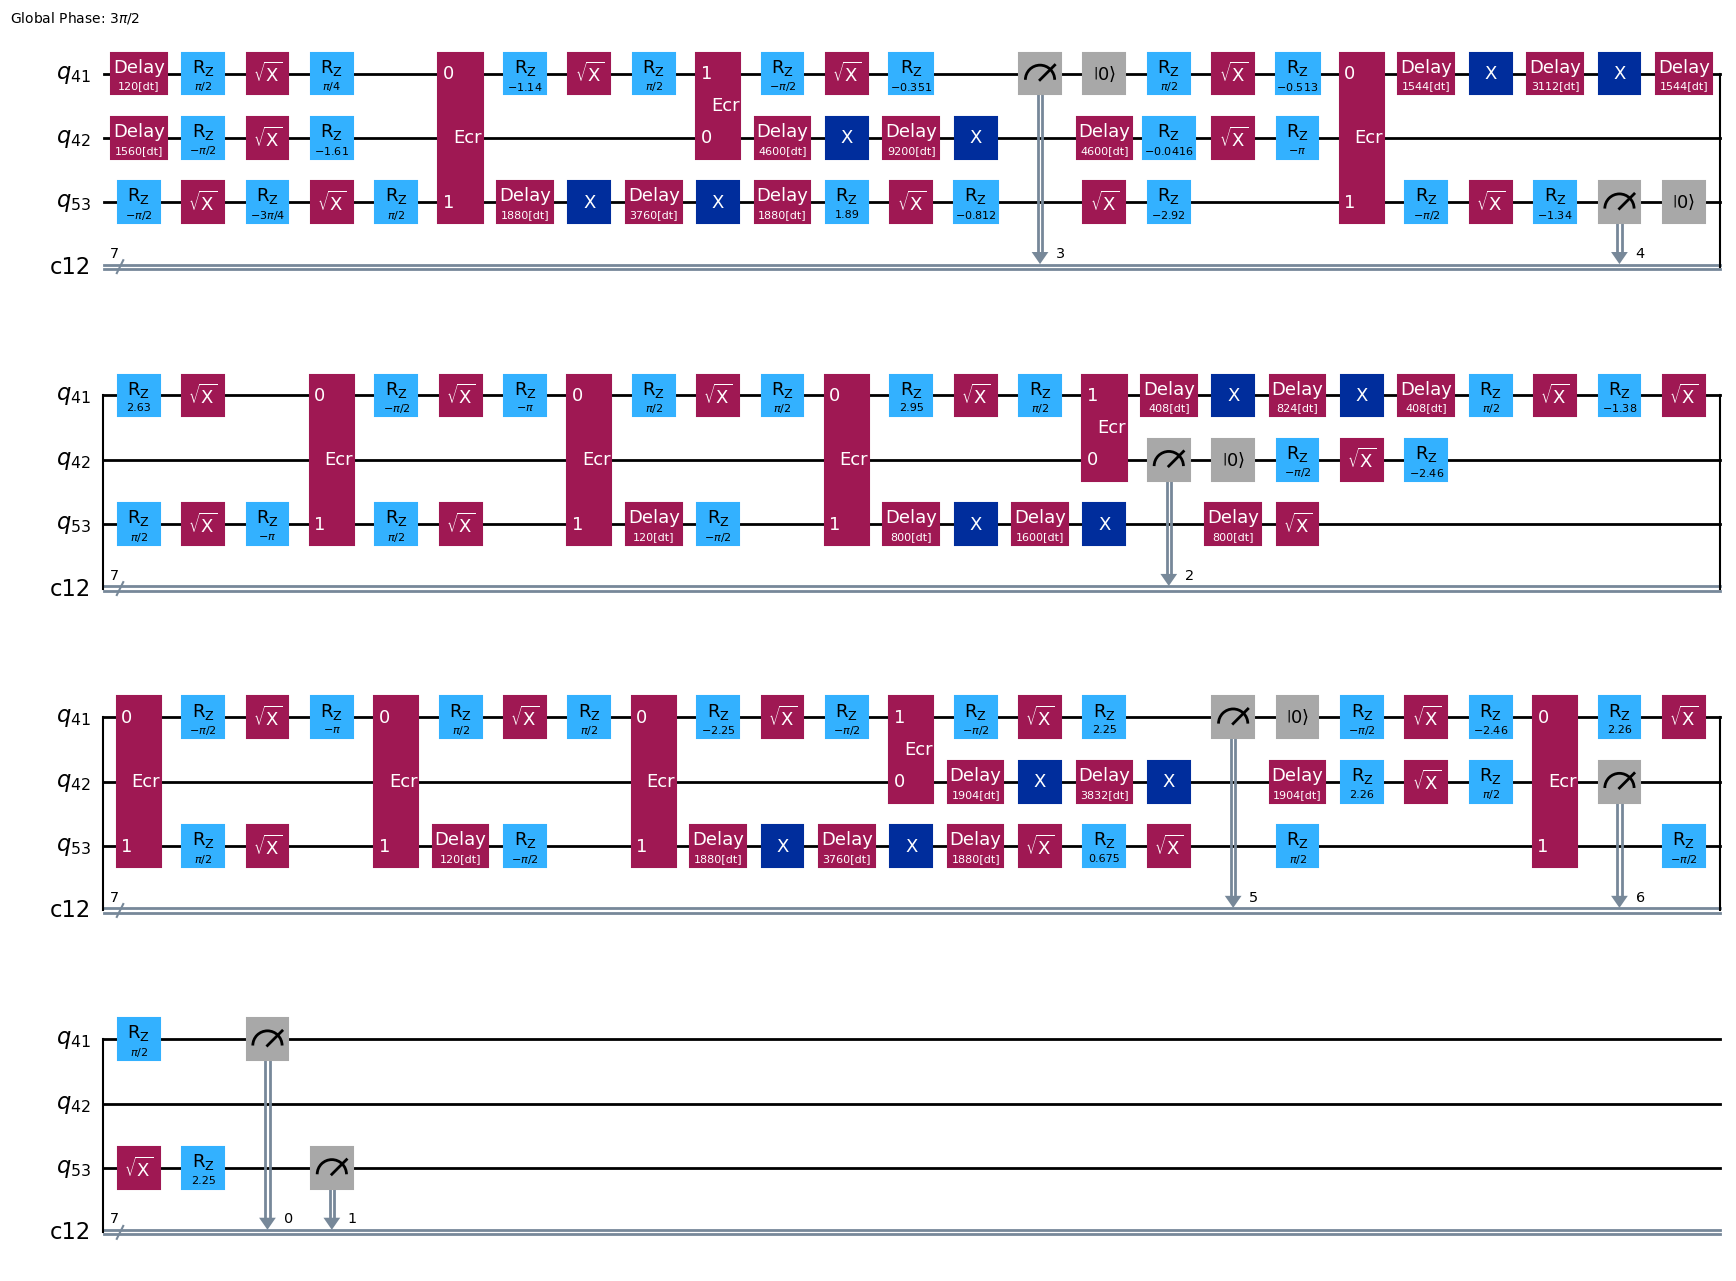

In [18]:
qc_dd_list[13].draw("mpl",idle_wires=False)

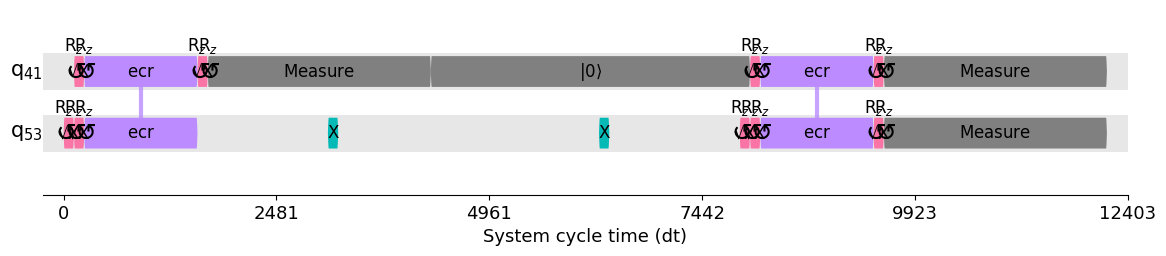

In [19]:
timeline_drawer(qc_dd_list[1], show_idle=False)

In [20]:
#Executing the circuit
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)
job = sampler.run(qc_transpiled_list,shots=1024)
print(job.job_id())

ctdayv3akxxg008mseq0


In [21]:
#Post-processing
import matplotlib.pyplot as plt
import statistics
from qiskit_ibm_runtime import QiskitRuntimeService

job_id = 'ctdayv3akxxg008mseq0' #Brisbane

service = QiskitRuntimeService()
job = service.job(job_id)
result_real = job.result()

In [22]:
print(result_real)
len(result_real)

PrimitiveResult([PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(c0=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(c4=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=5>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(c6=BitArray(<shape=(), num_shots=1024, num_bits=5>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=5>)

24

In [23]:
# For getting list of real counts of IBM brisbane (argument required for Fidelity)
counts_list_real=[]
k=0
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_static = result_real[(2*i*copies)+(2*j)].data    
        #data_dynamic_1 = result_real[(3*i*copies)+((3*j)+1)].data 
        data_dynamic_2 = result_real[(2*i*copies)+((2*j)+1)].data

        print(data_static)
        #print(data_dynamic_1)
        print(data_dynamic_2)
        
        counts_static=data_static.cr2.get_counts()
        #counts_dynamic_1=data_dynamic_1.cr2.get_counts()
        
        # Replacing 'cr3' with the appropriate attribute if needed
        dynamic_2_attr_name = f'c{2*(k)}'
        if hasattr(data_dynamic_2, dynamic_2_attr_name):
            counts_dynamic_2 = getattr(data_dynamic_2, dynamic_2_attr_name).get_counts()
        else:
            raise AttributeError(f"{dynamic_2_attr_name} not found in data_dynamic_2")
        
        counts_list_real.append(counts_static)
        #counts_list_real.append(counts_dynamic_1)
        counts_list_real.append(counts_dynamic_2)
        k=k+1

DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(c0=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(c4=BitArray(<shape=(), num_shots=1024, num_bits=3>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=5>))
DataBin(c6=BitArray(<shape=(), num_shots=1024, num_bits=5>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=5>))
DataBin(c8=BitArray(<shape=(), num_shots=1024, num_bits=5>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=5>))
DataBin(c10=BitArray(<shape=(), num_shots=1024, num_bits=5>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=7>))
DataBin(c12=BitArray(<shape=(), num_shots=1024, num_bits=7>))
DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=7>))
DataBin(c14=BitArray(<shape=(), num_shots=1024, num_bits=7>))
DataBin(cr2=B

In [24]:
#Calculation of lists of Fidelity mean and std deviation of real hardware simulation in ibm_brisbane
import statistics
from qiskit.quantum_info.analysis import hellinger_fidelity
# We will create 4 lists of Fidelities, for storing mean, std deviation of Fidelity, of copies of a circuit for fixed no of logical qubits
 
Fidelity_mean_static_brisbane=[]
#Fidelity_mean_dynamic_1_brisbane=[]
Fidelity_mean_dynamic_2_brisbane=[]

Fidelity_std_static_brisbane=[]
#Fidelity_std_dynamic_1_brisbane=[]
Fidelity_std_dynamic_2_brisbane=[]

Fidelity_copies_static_brisbane=[]
#Fidelity_copies_dynamic_1_brisbane=[]
Fidelity_copies_dynamic_2_brisbane=[]

for i in range(len(num_qubit_list)):
    
    for j in range(copies):
        
        Fidelity_static= hellinger_fidelity(counts_list_ideal[(2*i*copies)+(2*j)], counts_list_real[(2*i*copies)+(2*j)])
        #Fidelity_dynamic_1=hellinger_fidelity(counts_list_ideal[(3*i*copies)+((3*j)+1)], counts_list_real[(3*i*copies)+((3*j)+1)])
        Fidelity_dynamic_2=hellinger_fidelity(counts_list_ideal[(2*i*copies)+((2*j)+1)], counts_list_real[(2*i*copies)+((2*j)+1)])
        
        Fidelity_copies_static_brisbane.append(Fidelity_static)
        #Fidelity_copies_dynamic_1_brisbane.append(Fidelity_dynamic_1)
        Fidelity_copies_dynamic_2_brisbane.append(Fidelity_dynamic_2)

    
    Fidelity_mean_static_brisbane.append(statistics.mean(Fidelity_copies_static_brisbane))
    #Fidelity_mean_dynamic_1_brisbane.append(statistics.mean(Fidelity_copies_dynamic_1_brisbane))
    Fidelity_mean_dynamic_2_brisbane.append(statistics.mean(Fidelity_copies_dynamic_2_brisbane))
    
    Fidelity_std_static_brisbane.append(statistics.stdev(Fidelity_copies_static_brisbane))
    #Fidelity_std_dynamic_1_brisbane.append(statistics.stdev(Fidelity_copies_dynamic_1_brisbane))
    Fidelity_std_dynamic_2_brisbane.append(statistics.stdev(Fidelity_copies_dynamic_2_brisbane))
    
    Fidelity_copies_static_brisbane.clear()
    #Fidelity_copies_dynamic_1_brisbane.clear()
    Fidelity_copies_dynamic_2_brisbane.clear()

[0.9560183001356097, 0.932137474074229, 0.7887354051089467, 0.6161379747846863]
[0.8170469415001894, 0.4180344028415784, 0.2643629400026441, 0.17315477975814628]


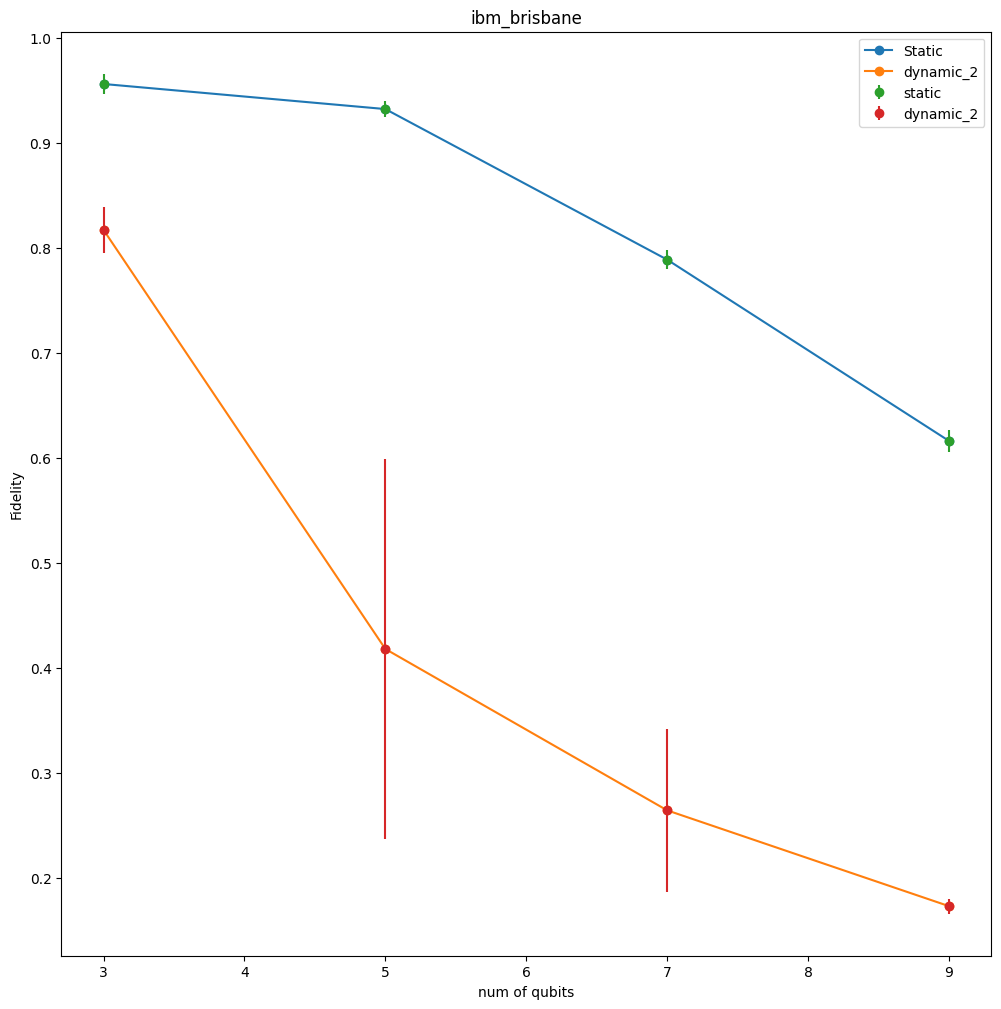

In [25]:
# Graph plotting
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
#figure(figsize=(16,12), dpi=180)
fig, ax1 = plt.subplots(1, 1, figsize=(12,12))

# Create  data.
ax1.set_xlabel('num of qubits')
ax1.set_ylabel('Fidelity')
ax1.set_title('ibm_brisbane')
x1 = num_qubit_list
y1_static = Fidelity_mean_static_brisbane
#y1_dynamic_1 = Fidelity_mean_dynamic_1_brisbane
y1_dynamic_2 = Fidelity_mean_dynamic_2_brisbane
print(y1_static)
#print(y1_dynamic_1)
print(y1_dynamic_2)
y_error_static =Fidelity_std_static_brisbane
#y_error_dynamic_1 =Fidelity_std_dynamic_1_brisbane
y_error_dynamic_2 =Fidelity_std_dynamic_2_brisbane
ax1.plot(x1, y1_static, 'o-',label='Static')
#ax1.plot(x1, y1_dynamic_1, 'o-',label='dynamic_1')
ax1.plot(x1, y1_dynamic_2, 'o-',label='dynamic_2')
ax1.errorbar(x1, y1_static,
			yerr = y_error_static, label='static',
			fmt ='o')
#ax1.errorbar(x1, y1_dynamic_1,
			#yerr = y_error_dynamic_1, label='dynamic_1',
			#fmt ='o')
ax1.errorbar(x1, y1_dynamic_2,
			yerr = y_error_dynamic_2, label='dynamic_2',
			fmt ='o')


plt.legend()
plt.show()